# Rasterize Census Data by spatial causal model results
This notebook walks through rasterizing the census data in the format of the spatial causal model results, so that we can directly compare the models.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import rasterio as rio

/var/folders/3r/mm1k6hx10zlgnb46j7vtvxz80000gq/T/ipykernel_24175/3827748209.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [8]:
# This code loads the census tract shapefile for Durham County
tracts = gpd.read_file('../data/preprocessed/census/census_tracts.shp')
block_groups = gpd.read_file('../data/preprocessed/census_blocks/durham_block_group.shp')

In [7]:
# Now, let's burn these values into a raster that is the same shape
# as the raster used for the weather underground data

# Open the source raster that we would like to copy
with rio.open("../data/preprocessed/spatial_causal_model_results/durham_temp_celsius.tif") as src:
    bounds = src.bounds
    res = src.res
    data = src.read(1)

print(bounds)
print(res)
print(data.shape)

BoundingBox(left=-8793570.0, bottom=4288500.0, right=-8770500.0, top=4311030.0)
(10.0, 10.0)
(2253, 2307)


Let's burn the GEOID into a raster, at the resolution of the spatial causal model results.

In [10]:
!gdalinfo ../data/preprocessed/spatial_causal_model_results/durham_temp_celsius.tif

Driver: GTiff/GeoTIFF
Files: ../data/preprocessed/spatial_causal_model_results/durham_temp_celsius.tif
Size is 2307, 2253
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            MEMBER["World Geodetic System 1984 (G2139)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation

In [16]:
tracts.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [30]:
# GEOID20
!gdal_rasterize -to SRC_SRS=EPSG:4269 -ot UInt64 -a GEOID20 -te {bounds[0]} {bounds[1]} {bounds[2]} {bounds[3]} -l census_tracts -tr {res[0]} {res[1]} -a_nodata -9999 -of GTiff -a_srs EPSG:3857 ../data/preprocessed/census/census_tracts.shp ../data/preprocessed/census/census_tracts_by_spatial_model_geoid.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [31]:
with rio.open("../data/preprocessed/census/census_tracts_by_spatial_model_geoid.tif") as src:
    bounds = src.bounds
    res = src.res
    data = src.read(1)

print(bounds)
print(res)
print(data.shape)

print()
print("Unique vals: ", np.unique(data))
print()
print("Length: ", len(np.unique(data)))

data[data < 0] = np.nan
plt.imshow(data)

BoundingBox(left=-8793570.0, bottom=4288500.0, right=-8770500.0, top=4311030.0)
(10.0, 10.0)
(2253, 2307)

Unique vals:  [          0 37063000101 37063000102 37063000200 37063000301 37063000302
 37063000401 37063000402 37063000500 37063000600 37063000700 37063000900
 37063001001 37063001002 37063001100 37063001301 37063001303 37063001304
 37063001400 37063001501 37063001503 37063001504 37063001505 37063001601
 37063001603 37063001604 37063001705 37063001706 37063001708 37063001709
 37063001710 37063001711 37063001712 37063001713 37063001801 37063001802
 37063001806 37063001808 37063001809 37063001810 37063001811 37063001900
 37063002007 37063002008 37063002009 37063002015 37063002019 37063002021
 37063002022 37063002023 37063002024 37063002025 37063002026 37063002029
 37063002030 37063002031 37063002032 37063002033 37063002034 37063002035
 37063002038 37063002100 37063002200 37063002300 37063980100]

Length:  65


ValueError: cannot convert float NaN to integer

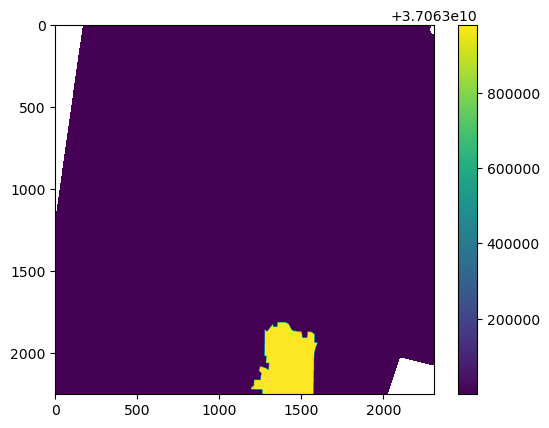

In [15]:
plt.imshow(data)
plt.colorbar()

Now, let's burn this data into the block groups

In [17]:
block_groups.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [18]:
block_groups.head()

,geoid,landarea,waterarea,pop,pop_error,income,income_err,geometry
0,370630018013,6464902.0,1821762.0,900.0,474.0,78324.0,1700.0,"POLYGON ((-78.82079 36.04266, -78.81975 36.043..."
1,370630017084,3576476.0,162732.0,1175.0,405.0,75729.0,57770.0,"POLYGON ((-78.89638 36.05947, -78.89558 36.060..."
2,370630016016,853369.0,71621.0,0.0,13.0,NaN,NaN,"POLYGON ((-78.90575 36.13901, -78.90548 36.139..."
3,370630020372,5587220.0,20203.0,2168.0,405.0,78250.0,16836.0,"POLYGON ((-78.86798 35.88224, -78.86712 35.882..."
4,370630020382,10845441.0,55347.0,1911.0,542.0,120875.0,62194.0,"POLYGON ((-78.85279 35.90356, -78.85278 35.904..."


In [20]:
!ogrinfo ../data/preprocessed/census_blocks/durham_block_group.shp -al

INFO: Open of `../data/preprocessed/census_blocks/durham_block_group.shp'
      using driver `ESRI Shapefile' successful.

Layer name: durham_block_group
Metadata:
  DBF_DATE_LAST_UPDATE=2024-01-25
Geometry: Polygon
Feature Count: 238
Extent: (-79.016305, 35.863210) - (-78.699316, 36.239320)
Layer SRS WKT:
GEOGCRS["NAD83",
    DATUM["North American Datum 1983",
        ELLIPSOID["GRS 1980",6378137,298.257222101,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4269]]
Data axis to CRS axis mapping: 2,1
geoid: String (80.0)
landarea: Real (24.15)
waterarea: Real (24.15)
pop: Real (24.15)
pop_error: Real (24.15)
income: Real (24.15)
income_err: Real (24.15)
OGRFeature(durham_block_g

In [24]:
block_groups.head()

,geoid,landarea,waterarea,pop,pop_error,income,income_err,geometry
0,370630018013,6464902.0,1821762.0,900.0,474.0,78324.0,1700.0,"POLYGON ((-78.82079 36.04266, -78.81975 36.043..."
1,370630017084,3576476.0,162732.0,1175.0,405.0,75729.0,57770.0,"POLYGON ((-78.89638 36.05947, -78.89558 36.060..."
2,370630016016,853369.0,71621.0,0.0,13.0,NaN,NaN,"POLYGON ((-78.90575 36.13901, -78.90548 36.139..."
3,370630020372,5587220.0,20203.0,2168.0,405.0,78250.0,16836.0,"POLYGON ((-78.86798 35.88224, -78.86712 35.882..."
4,370630020382,10845441.0,55347.0,1911.0,542.0,120875.0,62194.0,"POLYGON ((-78.85279 35.90356, -78.85278 35.904..."


In [25]:
!gdal_rasterize -to SRC_SRS=EPSG:4269 -a geoid -ot UInt64 -te {bounds[0]} {bounds[1]} {bounds[2]} {bounds[3]} -l durham_block_group -tr {res[0]} {res[1]} -a_nodata -9999 -of GTiff -a_srs EPSG:3857 ../data/preprocessed/census_blocks/durham_block_group.shp ../data/preprocessed/census_blocks/block_group_by_spatial_model_geoid.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


BoundingBox(left=-8793570.0, bottom=4288500.0, right=-8770500.0, top=4311030.0)
(10.0, 10.0)
(2253, 2307)

Unique vals:  [           0 370630001011 370630001012 370630001021 370630001022
 370630001023 370630001024 370630002001 370630002002 370630002003
 370630003011 370630003012 370630003013 370630003021 370630003022
 370630003023 370630004011 370630004012 370630004013 370630004021
 370630004022 370630005001 370630005002 370630005003 370630005004
 370630006001 370630006002 370630006003 370630007001 370630007002
 370630007003 370630009001 370630009002 370630010011 370630010012
 370630010013 370630010014 370630010021 370630010022 370630010023
 370630010024 370630010025 370630011001 370630011002 370630011003
 370630013011 370630013012 370630013031 370630013032 370630013041
 370630013042 370630014001 370630014002 370630015011 370630015031
 370630015041 370630015042 370630015051 370630015052 370630015053
 370630016011 370630016014 370630016035 370630016043 370630016044
 370630016047 3706300

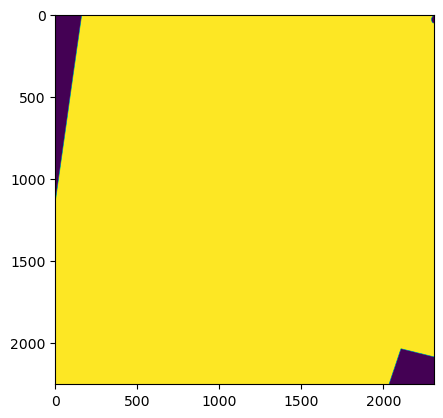

In [29]:
with rio.open("../data/preprocessed/census_blocks/block_group_by_spatial_model_geoid.tif") as src:
    bounds = src.bounds
    res = src.res
    data = src.read(1)

print(bounds)
print(res)
print(data.shape)

print()
print("Unique vals: ", np.unique(data))
print()
print("Length: ", len(np.unique(data)))

# data[data < 0] = None
plt.imshow(data)

In [27]:
print("Unique vals: ", np.unique(data))

Unique vals:  [           0 370630001011 370630001012 370630001021 370630001022
 370630001023 370630001024 370630002001 370630002002 370630002003
 370630003011 370630003012 370630003013 370630003021 370630003022
 370630003023 370630004011 370630004012 370630004013 370630004021
 370630004022 370630005001 370630005002 370630005003 370630005004
 370630006001 370630006002 370630006003 370630007001 370630007002
 370630007003 370630009001 370630009002 370630010011 370630010012
 370630010013 370630010014 370630010021 370630010022 370630010023
 370630010024 370630010025 370630011001 370630011002 370630011003
 370630013011 370630013012 370630013031 370630013032 370630013041
 370630013042 370630014001 370630014002 370630015011 370630015031
 370630015041 370630015042 370630015051 370630015052 370630015053
 370630016011 370630016014 370630016035 370630016043 370630016044
 370630016047 370630017051 370630017052 370630017053 370630017054
 370630017055 370630017061 370630017062 370630017063 370630017